In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout

In [ ]:
from networkx.drawing.nx_agraph import to_agraph
import graphviz

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

# **Pre-processing**
This section initializes the dataframe storing all the senator-donor data

In [ ]:
# get all data
df = pd.read_csv('https://raw.githubusercontent.com/Justin-Pascua/MATH-168-Group-Project/refs/heads/main/full_opensecrets_data.csv')

# filter down to top x-donors, where 0 <= x <= 100
x = 100
df = df.groupby('Senator').head(x).reset_index(drop = True)
df

,Senator,Party,Organization,Total,PACs,Individuals
0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258
1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042
2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684
3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683
4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576
...,...,...,...,...,...,...
9995,"Young, Todd",(R),Hilton Worldwide,26825,2500,24325
9996,"Young, Todd",(R),Mulzer Crushed Stone,26750,0,26750
9997,"Young, Todd",(R),Pilot Corp,26700,0,26700
9998,"Young, Todd",(R),North American Midway Entertainment,26600,0,26600


In [ ]:
# compute normalized contributions (i.e. normalize donation amounts so that weighted degree of each senator is 1)

# initialize normalized columns
df['Portion of Total'] = 0.0
df['Portion of PACs'] = 0.0
df['Portion of Individuals'] = 0.0

# get unique names
senators = df['Senator'].unique()

for senator in senators:
  # get entries corresponding to fixed senator
  temp_df = df[df['Senator'] == senator].copy()

  # compute totals for PACs, Individuals, and Total column
  pacs_total = temp_df['PACs'].sum()
  individuals_total = temp_df['Individuals'].sum()
  combined_total = pacs_total + individuals_total

  # divide each entry with corresponding total
  df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total']/combined_total
  df.loc[df['Senator'] == senator, 'Portion of PACs'] = temp_df['Individuals']/individuals_total
  df.loc[df['Senator'] == senator, 'Portion of Individuals'] = temp_df['PACs']/pacs_total

df

,Senator,Party,Organization,Total,PACs,Individuals,Portion of Total,Portion of PACs,Portion of Individuals
0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258,0.132522,0.188420,0.000000
1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042,0.054375,0.073848,0.008207
2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684,0.047083,0.066943,0.000000
3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683,0.024559,0.030562,0.010327
4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576,0.022973,0.032664,0.000000
...,...,...,...,...,...,...,...,...,...
9995,"Young, Todd",(R),Hilton Worldwide,26825,2500,24325,0.006222,0.007077,0.002861
9996,"Young, Todd",(R),Mulzer Crushed Stone,26750,0,26750,0.006205,0.007782,0.000000
9997,"Young, Todd",(R),Pilot Corp,26700,0,26700,0.006193,0.007768,0.000000
9998,"Young, Todd",(R),North American Midway Entertainment,26600,0,26600,0.006170,0.007739,0.000000


# **Graph Construction**
This section is used to construct the networkx objects for the bipartite network and the two projections

Here, the edge between a donor and a politician in the bipartite graph is weighted by the fraction of the total campaign funds that the donor accounts for. For example, if a donor contributed \$1,000 to a politician, and that politician has a total of \$20,000 in campaign funds from all donors, then the corresponding edge would have weight 1/20

In [ ]:
def construct_network(weight_by = 'Portion of Total'):
  # initialize graph
  bip_graph = nx.Graph()

  # add nodes for donors
  bip_graph.add_nodes_from(df['Organization'], bipartite = 0)

  # add nodes for senators
  bip_graph.add_nodes_from(df['Senator'], bipartite = 1)

  # get edges from df, weighted by normalized contributions
  edges = [(df['Organization'][i], df['Senator'][i], {'weight': df[weight_by][i]}) for i in range(len(df))]

  # add edges to graph
  bip_graph.add_edges_from(edges)

  row_nodes = list(df['Organization'].unique())
  col_nodes = list(df['Senator'].unique())

  # Get incidence matrix
  inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes)

  # Get weighted adjacency matrices using incidence matrix
  senator_proj_matrix = inc_matrix.T @ inc_matrix
  donor_proj_matrix = inc_matrix @ inc_matrix.T

  # Convert into arrays
  senator_proj_matrix = senator_proj_matrix.toarray()
  donor_proj_matrix = donor_proj_matrix.toarray()

  # Create projections using adjacency matrices
  senator_network = nx.from_numpy_array(senator_proj_matrix)
  donor_network = nx.from_numpy_array(donor_proj_matrix)

  # Add weighted degree to attributes of each node
  for i in range(100):
    senator_network.nodes[i]['Weighted Degree'] = senator_proj_matrix[i].sum()

  for i in donor_network.nodes:
    donor_network.nodes[i]['Weighted Degree'] = donor_proj_matrix[i].sum()

  return bip_graph, senator_proj_matrix, donor_proj_matrix, senator_network, donor_network, col_nodes


In [ ]:
bip_graph, senator_proj_matrix, donor_proj_matrix, senator_network, donor_network, col_nodes = construct_network()


# **Identifying Edges of Highest Weight**
This section is used to identify which edges in the senator projection have the highest weights

Below, we list the edges (and the corresponding pair of senators that are joined by that edge) sorted from highest weight to lowest

In [ ]:
# List senator pairs from highest to lowest edge weight
edge_weights_df = pd.DataFrame(columns = ["Senator Pair", "Edge Weight"], index = range(4950))

# Iterate over all unordered pairs of senators
N = 0
for i in range(100):
  for j in range(i):
    # Record names of senators in pari
    edge_weights_df.iloc[N, 0] = f"{senators[i]} and {senators[j]}"
    try:
      # If edge exists, record weight
      edge_weights_df.iloc[N, 1] = senator_network.edges[(i,j)]['weight']
    except:
      # Otherwise, nothing
      pass
    N += 1

# Sort by weight
edge_weights_df.sort_values('Edge Weight', ascending = False, inplace = True)

# Drop any pairs not connected by an edge
edge_weights_df.dropna(inplace = True)

# Reset indices
edge_weights_df.reset_index(inplace = True, drop = True)

edge_weights_df

,Senator Pair,Edge Weight
0,"Masto, Catherine Cortez and Duckworth, Tammy",0.030583
1,"Rosen, Jacky and Masto, Catherine Cortez",0.030409
2,"Rosen, Jacky and Duckworth, Tammy",0.024096
3,"Lummis, Cynthia and Hawley, Josh",0.023394
4,"Sinema, Kyrsten and Rosen, Jacky",0.021244
...,...,...
4933,"Tuberville, Tommy and Masto, Catherine Cortez",0.000044
4934,"Warren, Elizabeth and Marshall, Roger",0.000044
4935,"Markey, Ed and Kennedy, John",0.00004
4936,"Johnson, Ron and Cantwell, Maria",0.000037


In [ ]:
# Finding common donors of Duckworth and Masto
duckworth_df = df[df['Senator'] == 'Duckworth, Tammy'].copy()
duckworth_donors = set(duckworth_df['Organization'])

masto_df = df[df['Senator'] == 'Masto, Catherine Cortez'].copy()
masto_donors = set(masto_df['Organization'])

common_donors = duckworth_donors & masto_donors
common_donors

{'AT&T Inc',
 'Air Line Pilots Assn',
 'Akin, Gump et al',
 'American Assn for Justice',
 'Bend The Arc Jewish Action',
 'Berkshire Hathaway',
 'Blue Cross/Blue Shield',
 'Charter Communications',
 'Cigna Corp',
 'Clifford Law Offices',
 'Comcast Corp',
 'Cooney & Conway',
 'Council for a Livable World',
 'Deloitte LLP',
 'Democratic Senatorial Campaign Cmte',
 "EMILY's List",
 'Great Lakes PAC',
 'Honeywell International',
 'International Brotherhood of Electrical Workers',
 'Ironworkers Union',
 'JStreetPAC',
 'League of Conservation Voters',
 'Motley Rice LLC',
 'NCTA The Internet & Television Assn',
 'National Air Traffic Controllers Assn',
 'Northrop Grumman',
 'Pfizer Inc',
 'Sheet Metal, Air, Rail & Transportation Union',
 'Thornton Law Firm',
 'Transport Workers Union',
 'UNITE HERE',
 'United Food & Commercial Workers Union',
 'UnitedHealth Group',
 'University of California',
 'Womencount PAC'}

In [ ]:
# Finding common donors of Sanders and Hagerty
sanders_df = df[df['Senator'] == 'Sanders, Bernie'].copy()
sanders_donors = set(sanders_df['Organization'])

hagerty_df = df[df['Senator'] == 'Hagerty, Bill'].copy()
hagerty_donors = set(hagerty_df['Organization'])

common_donors = sanders_donors & hagerty_donors
common_donors

{'Home Depot'}

# **Visualizations of the bipartite network**

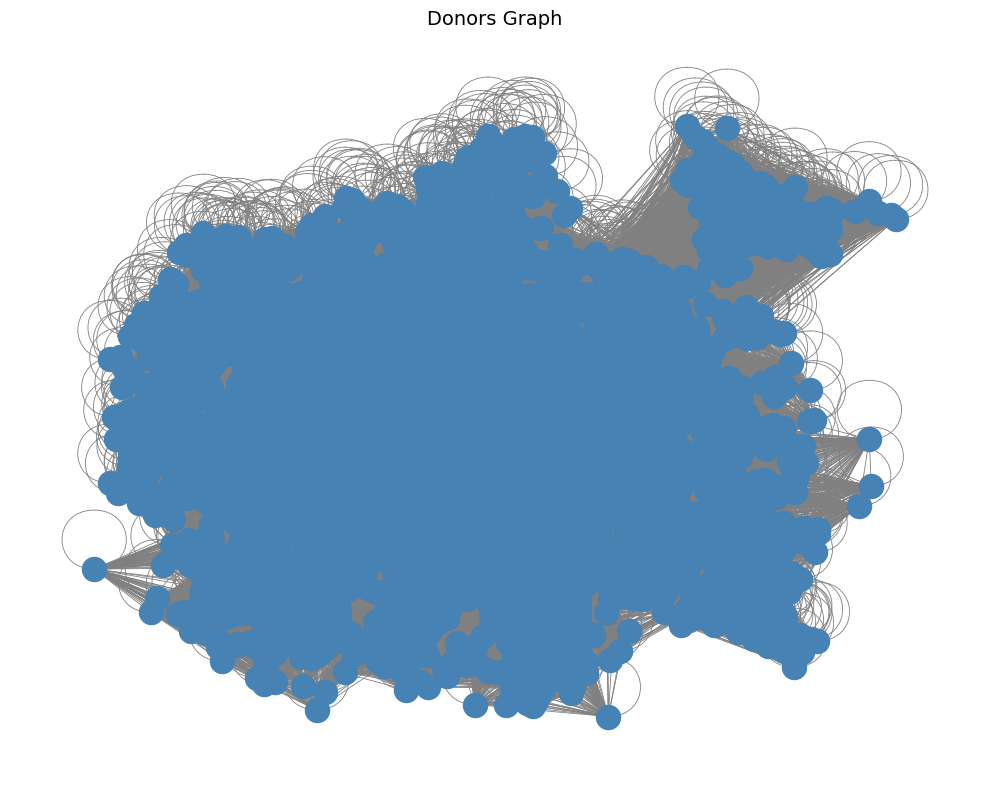

In [ ]:
plt.figure(figsize=(10, 8))

# layout
pos = nx.spring_layout(donor_network, seed=1)

# draw nodes (blue circles)
nx.draw_networkx_nodes(donor_network, pos, node_color='steelblue', node_size=300)

# draw edges (thin grey lines)
nx.draw_networkx_edges(donor_network, pos, edge_color='grey', width=0.6)

# optional: senator names
#nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Donors Graph", fontsize=14)   # ← label for the whole graph
plt.axis('off')
plt.tight_layout()
plt.show()

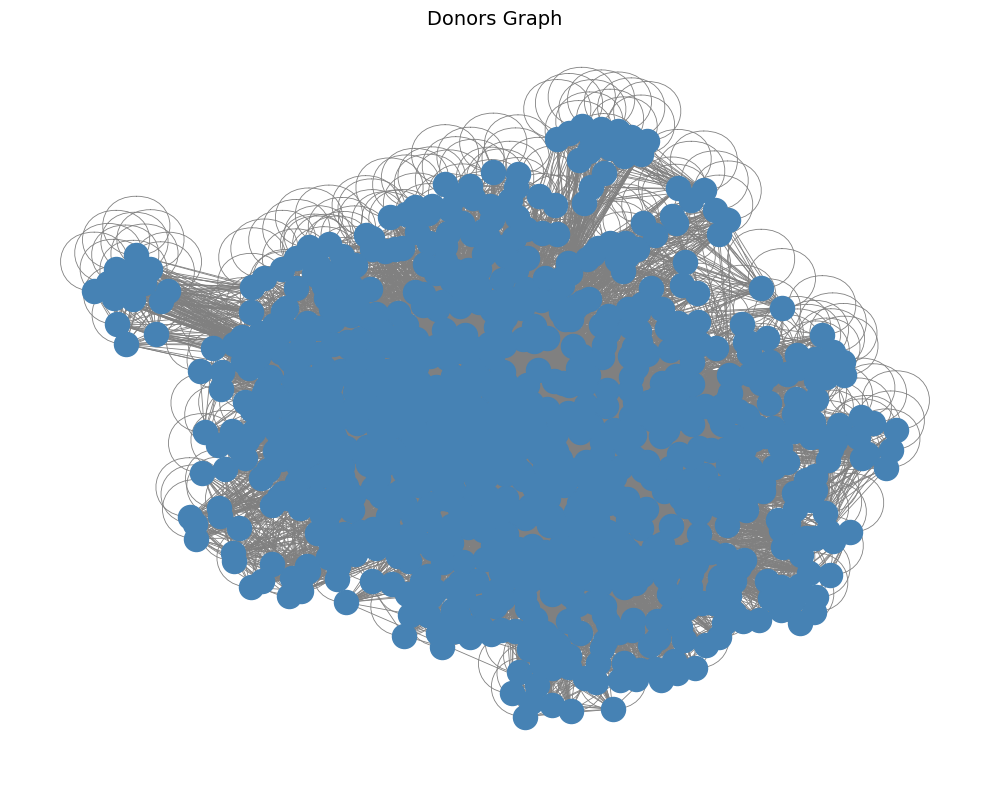

In [ ]:
plt.figure(figsize=(10, 8))

# layout
pos = nx.spring_layout(donor_network, seed=1)

# draw nodes (blue circles)
nx.draw_networkx_nodes(donor_network, pos, node_color='steelblue', node_size=300)

# draw edges (thin grey lines)
nx.draw_networkx_edges(donor_network, pos, edge_color='grey', width=0.6)

# optional: senator names
#nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Donors Graph", fontsize=14)   # ← label for the whole graph
plt.axis('off')
plt.tight_layout()
plt.show()

## **Converting to Gephi comptaible graphs**

In [ ]:
#converting to Gephi compatible format

# Add bipartite attribute (redundant but ensures all nodes have it)
top_nodes = df['Organization'].unique()
bottom_nodes = df['Senator'].unique()

nx.set_node_attributes(bip_graph, {n: 0 for n in top_nodes}, "bipartite")
nx.set_node_attributes(bip_graph, {n: 1 for n in bottom_nodes}, "bipartite")

# Export to GEXF
nx.write_gexf(bip_graph, "bipartite_graph.gexf")

# Download in Colab
from google.colab import files
files.download("bipartite_graph.gexf")






# OPTIONAL: Add any node attributes you want Gephi to see — already done if you've added "Weighted Degree"
# Example:
# for n in senator_network.nodes:
#     senator_network.nodes[n]['label'] = sorted_senators[n]  # If nodes are indexed by int

# Save senator projection network
nx.write_gexf(senator_network, "senator_network.gexf")

# Save donor projection network
nx.write_gexf(donor_network, "donor_network.gexf")

from google.colab import files
files.download("senator_network.gexf")
files.download("donor_network.gexf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Degree Distributions**

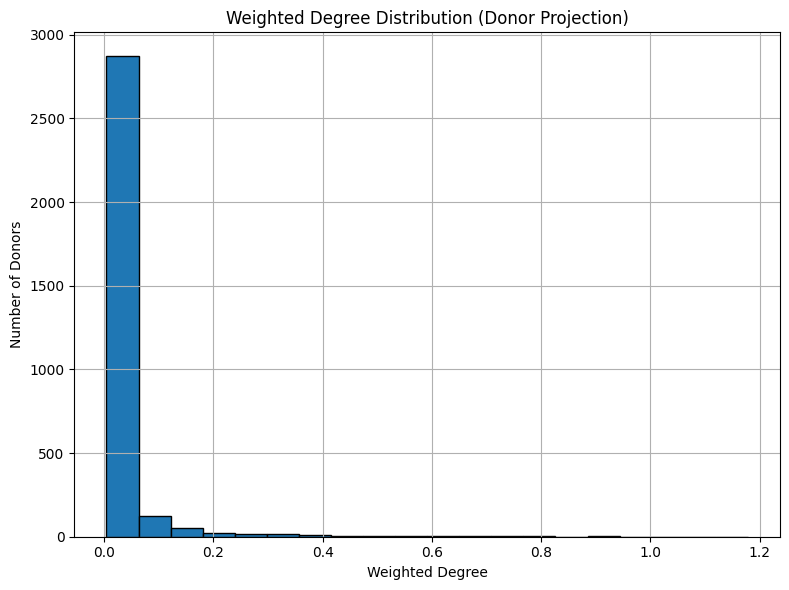

In [ ]:
# Get weighted degrees
donor_weighted_degrees = [deg for _, deg in donor_network.degree(weight='weight')]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(donor_weighted_degrees, bins=20, edgecolor='black')
plt.xlabel("Weighted Degree")
plt.ylabel("Number of Donors")
plt.title("Weighted Degree Distribution (Donor Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

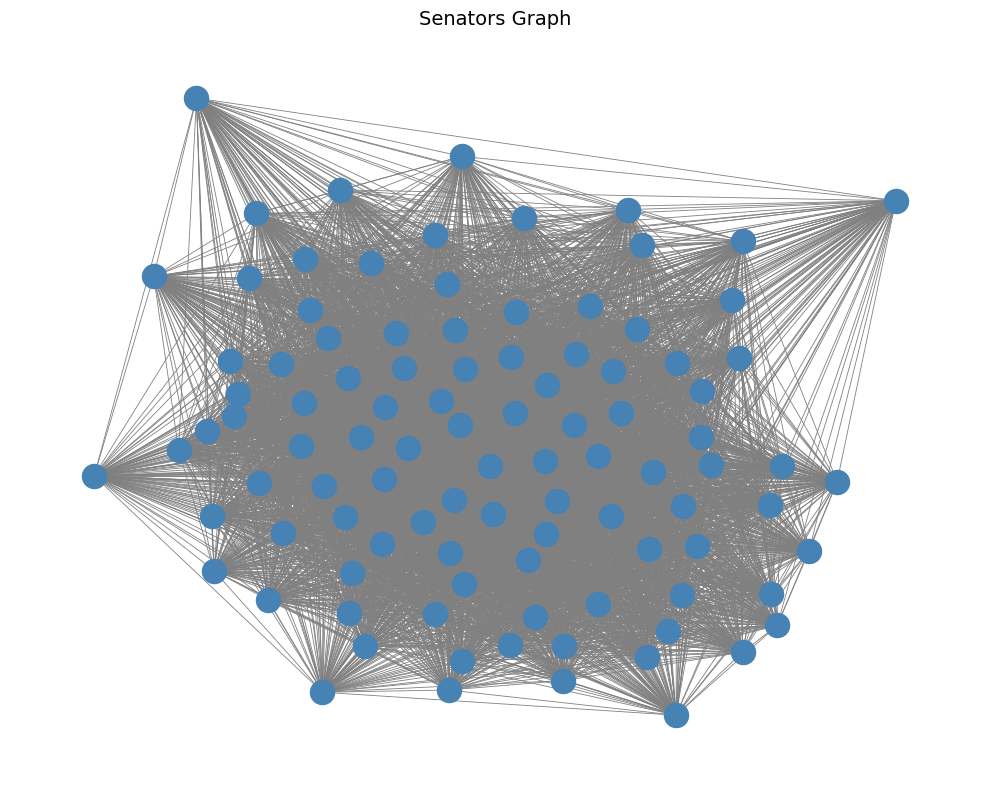

In [ ]:
plt.figure(figsize=(10, 8))

# layout
pos = nx.spring_layout(senator_network, seed=1)

# draw nodes (blue circles)
nx.draw_networkx_nodes(senator_network, pos, node_color='steelblue', node_size=300)

# draw edges (thin grey lines)
nx.draw_networkx_edges(senator_network, pos, edge_color='grey', width=0.6)

# optional: senator names
#nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Senators Graph", fontsize=14)   # ← label for the whole graph
plt.axis('off')
plt.tight_layout()
plt.show()

# **Degree Distribution of Senators Graph**

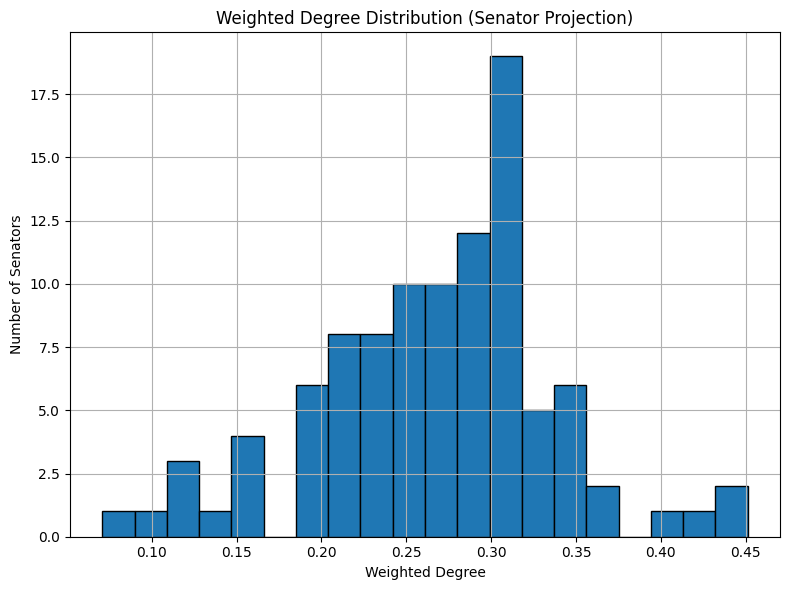

In [ ]:
# Get weighted degrees
senator_weighted_degrees = [deg for _, deg in senator_network.degree(weight='weight')]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(senator_weighted_degrees, bins=20, edgecolor='black')
plt.xlabel("Weighted Degree")
plt.ylabel("Number of Senators")
plt.title("Weighted Degree Distribution (Senator Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Heatmap construction**

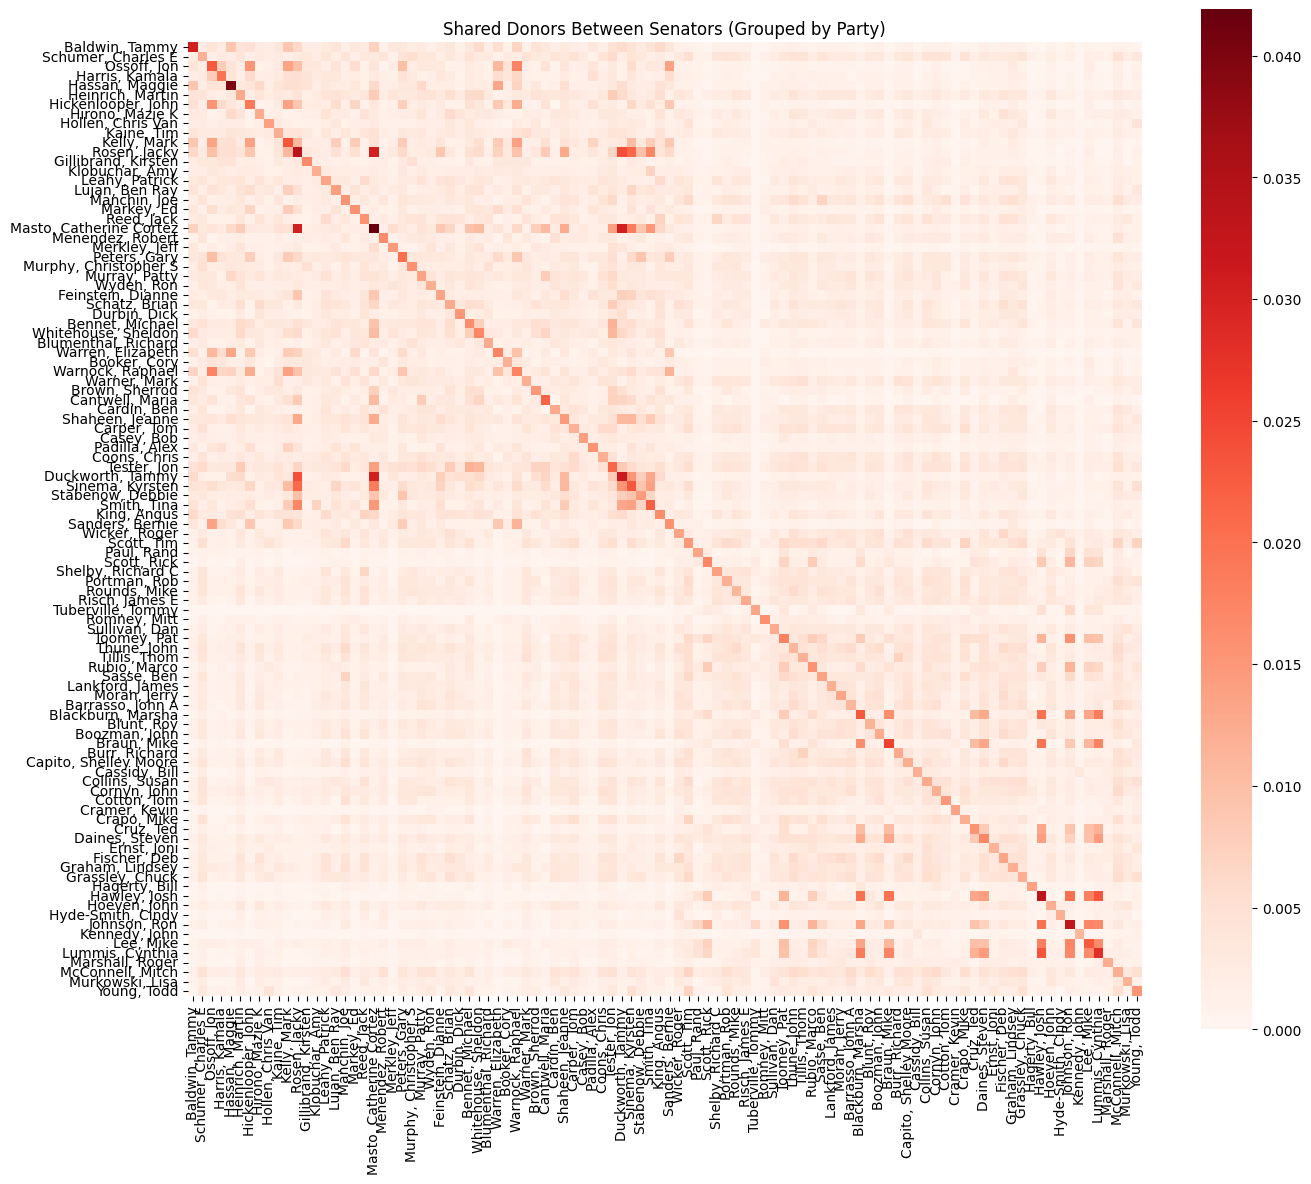

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get unique senators and their party affiliations
senator_parties = df[['Senator', 'Party']].drop_duplicates().set_index('Senator')['Party']
# 'senator_parties' is a Series mapping each senator to 'D', 'R', or 'I'

# Get column order for senator_proj_matrix (you already use this when building col_nodes)
# Reorder senator list by party
senator_party_df = pd.DataFrame({'Senator': col_nodes})
senator_party_df['Party'] = senator_party_df['Senator'].map(senator_parties)
senator_party_df = senator_party_df.sort_values('Party')

# Reorder the projection matrix rows and columns
sorted_senators = senator_party_df['Senator'].tolist()
sorted_indices = [col_nodes.index(senator) for senator in sorted_senators]
sorted_matrix = senator_proj_matrix[np.ix_(sorted_indices, sorted_indices)]

# Create a heatmap DataFrame
heatmap_df = pd.DataFrame(sorted_matrix, index=sorted_senators, columns=sorted_senators)

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_df, cmap='Reds', xticklabels=True, yticklabels=True, square=True)
plt.title('Shared Donors Between Senators (Grouped by Party)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Heatnap 2nd attempt

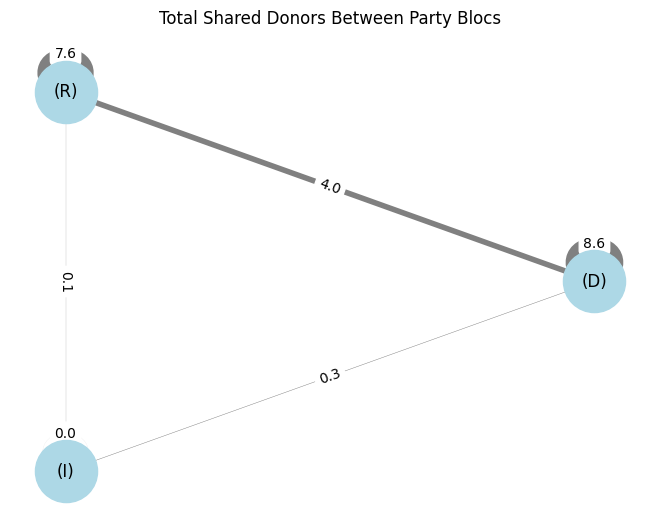

In [ ]:
import networkx as nx

G = nx.Graph()

# Add nodes for each party
G.add_nodes_from(parties)

# Add edges with weights from the party_matrix
for i in parties:
    for j in parties:
        if i <= j:  # avoid duplicates
            G.add_edge(i, j, weight=party_matrix.loc[i, j])

# Draw graph
pos = nx.circular_layout(G)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, width=weights, edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f'{v:.1f}' for k, v in labels.items()})
plt.title("Total Shared Donors Between Party Blocs")
plt.show()


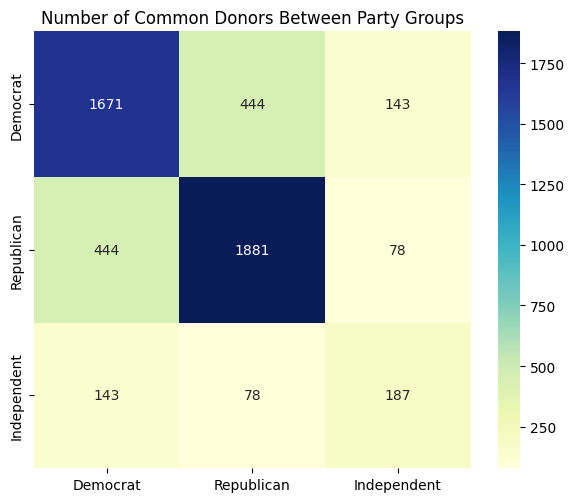

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

# Step 1: Group donors per party
# Convert to dictionary of sets
party_donor_map = df.groupby('Party')['Organization'].apply(set).to_dict()

# Ensure all 3 parties are present
for party in ['(D)', '(R)', '(I)']:
    if party not in party_donor_map:
        party_donor_map[party] = set()

# Step 2: Compute number of shared donors between party pairs
parties = ['(D)', '(R)', '(I)']
common_donors_matrix = pd.DataFrame(index=parties, columns=parties, dtype=int)

for p1, p2 in combinations_with_replacement(parties, 2):
    shared = party_donor_map[p1] & party_donor_map[p2]
    count = len(shared)
    common_donors_matrix.loc[p1, p2] = count
    common_donors_matrix.loc[p2, p1] = count  # symmetric

# Step 3: Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(common_donors_matrix.astype(int), annot=True, fmt='d', cmap='YlGnBu', square=True,
            xticklabels=['Democrat', 'Republican', 'Independent'],
            yticklabels=['Democrat', 'Republican', 'Independent'])
plt.title('Number of Common Donors Between Party Groups')
plt.tight_layout()
plt.show()


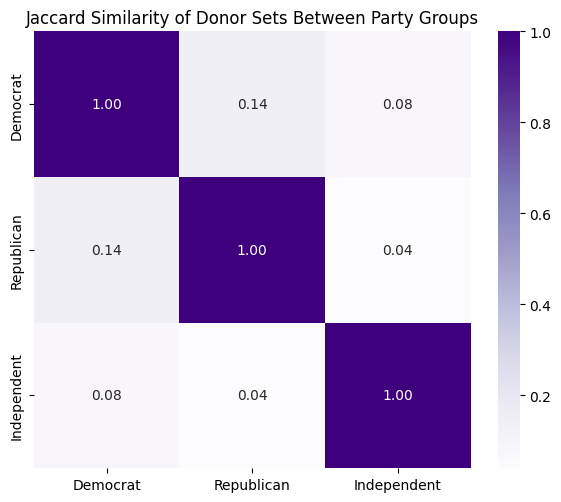

In [ ]:
# Step 2: Compute Jaccard similarities
parties = ['(D)', '(R)', '(I)']
jaccard_matrix = pd.DataFrame(index=parties, columns=parties, dtype=float)

for p1, p2 in combinations_with_replacement(parties, 2):
    donors1 = party_donor_map[p1]
    donors2 = party_donor_map[p2]
    intersection = donors1 & donors2
    union = donors1 | donors2
    similarity = len(intersection) / len(union) if union else 0.0
    jaccard_matrix.loc[p1, p2] = similarity
    jaccard_matrix.loc[p2, p1] = similarity  # symmetric

# Step 3: Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(jaccard_matrix.astype(float), annot=True, fmt=".2f", cmap='Purples', square=True,
            xticklabels=['Democrat', 'Republican', 'Independent'],
            yticklabels=['Democrat', 'Republican', 'Independent'])
plt.title('Jaccard Similarity of Donor Sets Between Party Groups')
plt.tight_layout()
plt.show()